# DS1003 HW2 Zian Jiang

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Computing Risk 

### Q1

### a

$$E(\Vert \vec{x} \Vert_2^2) = E(x_1^2 + ... + x_n^2) = E(x_1^2)+...+E(x_n^2) = \frac{(4+4+1+1+0)n}{5} = 2n$$

### b

$$E(\Vert \vec{x} \Vert_{\infty}) = E(\max_{i}(|x_i|))$$. $$P(|X|=0)=\frac{1}{5},P(|X|=1)=\frac{1}{5},P(|X|=2)=\frac{2}{5}$$, so $$E(\Vert \vec{x} \Vert_{\infty}) = \frac{1}{5} + 2*\frac{2}{5} + 3*\frac{2}{5} = \frac{11}{5}$$


### c

$$cov(\vec{x}) = \text{np.diag(2*np.ones(n))}$$ since all $x_i$'s are i.i.d chosen ($cov(x_i,x_j)=0 \forall i\neq j$) and $cov(x_i,x_i)) = Var(x_i) = E(x_i^2) + 0 = 2.$

### Q2

### a

Let $$MSE(a) = E((a-y)^2),$$ by definition of variance, we have $$MSE(a) = (E(a-y))^2 + Var(a-y) = (a-E(y))^2 + Var(y).$$ Thus, since only $y$ is random, we cannot minimize the value of $Var(y)$, which is the **_Bayes risk._** The best we can do is setting $a_* = E(y)$ to minimize the first term to $0$.

### b

### i

Following similar arguments in part a, $$E((a-y)^2|x) = (E(a-y)|x)^2 + Var(a-y|x) = = (a-E(y|x))^2 + Var(y|x).$$ Since $Var(y|x)$ we cannot minimize to 0, the best we can do is setting $a_* = E(y|x).$

### ii

We know $$\forall x, E((a-y)^2|x) \leq E((a-y)^2|x).$$ Then $$E(E((a-y)^2|x)) = E(E((a-y)^2|x))$$ is also true. By law of iteration, this means $$\forall f, E((a-y)^2) \leq E((f(x)-y)^2).$$

## Linear Regression

### Q1: Feature normalization

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test - test set, a 2D numpy array of size (num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    indices = []
    
    for feature in range(train.shape[1]):
        column = train[:,feature]
        indices.append(~np.isclose(column, column[0]).all())
        
    train = train[:,indices]
    test = test[:,indices]
    mins = np.min(train,axis=0)
    maxs = np.max(train,axis=0)
    
    train_normalized = (train-mins)/(maxs-mins)
    test_normalized = (test-mins)/(maxs-mins)
    
    return train_normalized,test_normalized
    

### Q2

### a

$$J(\theta) = ((X\theta-Y)^T(X\theta-Y))/n$$

### b

$$J'(\theta) = 2 * \text{np.mean}(X(X\theta-Y))$$

### c

$$J(\theta + \eta h) - J(\theta) \approx \eta h^TJ'(\theta)$$

### d

$$\theta^{t+1} := \theta^{t} - \eta J'(\theta^{t})$$

### e

In [3]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the average square loss, scalar
    """
    return np.dot(np.transpose(np.dot(X,theta)-y),np.dot(X,theta)-y)/y.shape[0]

### f

In [4]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    
    return 2 * np.mean((np.dot(X,theta)-y).reshape(-1,1)*X,axis=0) 
    

### Q3

In [5]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    sum = 0
    
    for i in range(num_features):
        e_i = np.zeros(num_features)
        e_i[i] = 1
        approx_grad = (compute_square_loss(X,y,theta + epsilon*e_i) - compute_square_loss(X,y,theta - epsilon*e_i))/(2*epsilon)
        sum += abs(approx_grad-true_gradient[i])
        
    return sum/num_features < tolerance

### Q4

### a

In [6]:
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step (num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array, (num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    theta = np.zeros(num_features) #Initialize theta
    theta_hist[0,:] = theta
    loss_hist[0] = compute_square_loss(X,y,theta)
    
    for i in range(1,num_step+1):
        theta -= alpha * compute_square_loss_gradient(X,y,theta)
        theta_hist[i,:] = theta
        loss_hist[i] = compute_square_loss(X,y,theta)
    
    return theta_hist,loss_hist

### b

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


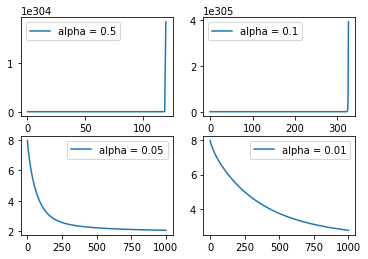

In [7]:
#Loading the dataset
print('loading the dataset')

df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))  # Add bias term

step_sizes = [0.5,0.1,0.05,0.01]
losses = []

for i,alpha in enumerate(step_sizes):
    _,loss_hist = batch_grad_descent(X_train,y_train,alpha=alpha)
    losses.append(loss_hist)
    plt.subplot(2,2,i+1)
    plt.plot(loss_hist,label="alpha = " + str(alpha))
    plt.legend()
    

As we can see, the algorithm may diverge if the learning rate is too big, for example 0.5 or 0.1.

## Ridge Regression

### Q1

$$J'(\theta) = 2 * \text{np.mean}(X(X\theta-Y)) + 2 \lambda \theta$$

### Q2

In [8]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    return 2 * np.mean((np.dot(X,theta)-y).reshape(-1,1)*X,axis=0) + 2*lambda_reg*theta

### Q3

In [13]:
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step (num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    theta = np.zeros(num_features) #Initialize theta
    theta_hist[0,:] = theta
    loss_hist[0] = compute_square_loss(X,y,theta)
    
    for i in range(1,num_step+1):
        theta -= alpha * compute_regularized_square_loss_gradient(X,y,theta,lambda_reg)
        theta_hist[i,:] = theta
        loss_hist[i] = compute_square_loss(X,y,theta)
    
    return theta_hist,loss_hist

### Q4

Because the bias term is $B*\theta_{d+1}$, and we are adjusting $\theta_{d+1}$. If B is large, then $\theta_{d+1}$ can be adjusted small and the regularization is small compared to the entire regularization.

### Q5

In [10]:
#Loading the dataset
print('loading the dataset')

df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))  # Add bias term

thetas = []
losses = []
lambdas = [1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1]

for i,lambd in enumerate(lambdas):
    theta_hist,loss_hist = regularized_grad_descent(X_train,y_train,lambda_reg=lambd)
    losses.append(loss_hist)
    thetas.append(theta_hist)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


Text(0.5, 1.0, 'testing loss')

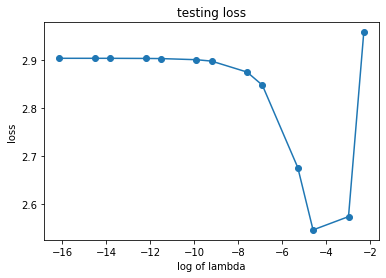

In [11]:
best_thetas = [theta[-1,:] for theta in thetas]
test_losses = [compute_square_loss(X_test,y_test,theta) for theta in best_thetas]
plt.plot(np.log(lambdas),test_losses,"o-")
plt.xlabel("log of lambda")
plt.ylabel("loss")
plt.title("testing loss")


In [12]:
print(lambdas[np.argmin(test_losses)])

0.01


### Q6

I would use the theta trained with 0.01 as the regularization parameter since the theta trained with 0.01 regularztion has the lowest loss on the testing set, which means this theta generalizes the best.

## Stochastic Gradient Descent

### Q1 

$$f_i(\theta)= (h_{\theta}(x_i)-y_i)^2 + m\lambda\theta^T\theta$$

### Q2

Since $i$ is uniformaly drawn from $\{1,2,...,m\}$, each $i$ has the same probability $\frac{1}{m}$ of being chosen. Thus, according to the definition of expectation, $$E(\nabla f_i(\theta)) = \sum_{i=1}^{m}\frac{1}{m}\nabla f_i(\theta) = \frac{1}{m}\sum_{i=1}^{m}\nabla f_i(\theta) = \nabla J(\theta)$$

### Q3

For each epoch, shuffle $D = \{1,2,...,m\}$, then do $$\theta \leftarrow \theta - \alpha(\frac{2}{m}(\theta^T x_i-y_i )x_i + \lambda\theta) \hspace{0.2cm}\text{for } i \in D$$

### Q4

In [58]:
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch (num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size (num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    C = 0.1
    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    
    if isinstance(alpha, str):
        if alpha == "C/sqrt(t)":
            sqrt = True
        else:
            sqrt = False
            
    for i in range(num_epoch):
        shuffle = np.arange(num_instances)
        np.random.shuffle(shuffle)
        if isinstance(alpha, str):
            if i == 0:
                alpha = C
            else:
                alpha = C/np.sqrt(i) if sqrt else C/i
        for j in shuffle:
            theta -= 2 * alpha * ((np.dot(theta,X[j,:]) - y[j]) * X[j,:] + lambda_reg*theta)/num_instances
            loss_hist[i,j] = compute_square_loss(X,y,theta)
            theta_hist[i,j,:] = theta
    return theta_hist,loss_hist
        

In [59]:
#Loading the dataset
print('loading the dataset')

df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))  # Add bias term

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


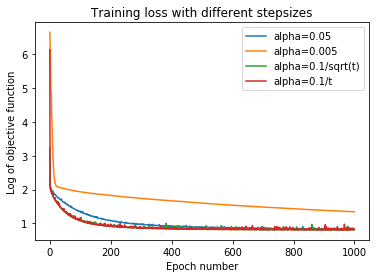

In [64]:
alphas = [0.05,0.005,"0.1/sqrt(t)","0.1/t"]
thetas = []
losses = []

for alpha in alphas:
    theta_hist,loss_hist = stochastic_grad_descent(X_train, y_train, alpha=alpha,lambda_reg=0.01, num_epoch=1000)
    thetas.append(theta_hist)
    losses.append(loss_hist)
    plt.plot(range(loss_hist.shape[0]),np.log(loss_hist[:,-1]),label="alpha="+str(alpha))
    plt.xlabel("Epoch number")
    plt.ylabel("Log of objective function")
    plt.legend()
    plt.title("Training loss with different stepsizes")

As we can see from the plot above, out of the 4 stepsize setups, alpha = 0.1/step_size has the best training loss.